In [3]:
import os

import PIL
from PIL import Image
from PIL.ImageDraw import Draw

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.ndimage import affine_transform
from tensorflow.keras import backend as K

import pandas as pd
from tqdm import tqdm

In [4]:
# !wget https://www.kaggleusercontent.com/kf/4346884/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..DyxYyheDh_RA5kd4_MHPwQ.875NZZPJbHPYKhkWxQjO1tIJ01qGMAJ694LuYv3CyQNrCrpFKPRXXjhvOt7-Aa6SxPWVNeo5F1_8K25uGevhDpq4xSvoeoqwNt1t0iMTglPBXCZh5cua_j4eZ2ezs9MnAKzQBeyxDxj8Z6cYpxnat56CkDUIIbjnJZL0o47Afgdk9nmIMZtlgfDJ-OH4XZ1Pv-Eg6wyw9ngGBjIVCjnxCxSHS2lYalz-IsIP5wRIjOxVMrUMDgR_AGgkCIvOgkHpMDXTpoPHJ53czO3zkMQ86GBIQAQcoZcHQzpkdE-gEaeDycqK5B_gH865TtbLK64tw0Rr2_F7u8uikrKgqVHMU8tflZbyzUbWconcEZ24dQ7ojWkuCs2mvdiIyoWLzaPCsE_pMoLAo1i0ytrEWyGHemb9kTnaVDRIIlktevTAefNf0uPzwfQE-U9MwzBcpJtKQ0magKgLg8Xu6mV_YmcU0zFx4Wl51cU9doB-9kh1L9ot6y9sIKAD733cqmiCvhblmK_cwU5hAt7cW28BiaVrtoIkJuAkvrkhvmDIYhHFX4klj9Yv4TAKq0BZ8rmmXuc403MRPLNGqSLYz5Rv-jltXxnQMYIt2kCZmHGklbJU6OUyY2WXhCzZ1yZB1F-mtvd2vwwb_P6HOk8zLCOx5ODy5DMcFA5s5-eb2Qpo9ADpUq8.fJT6QVF86y6-GG6dz0fkzA/cropping.model

In [5]:
DATA = '../WC_input/data'

In [6]:
model = load_model('cropping_2.model')

In [7]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 192, 384, 64) 5248        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 192, 384, 64) 36928       conv2d_34[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 192, 384, 64) 256         conv2d_35[0][0]                  
____________________________________________________________________________________________

In [8]:
data_paths = [img for img in os.listdir(DATA)]

In [26]:

# Define useful constants
img_shape  =  (192, 384, 1) # (128, 128, 1) # 
# anisotropy = 2.15
anisotropy = 1

def center_transform(affine, input_shape):
    hi, wi = float(input_shape[0]), float(input_shape[1])
    ho, wo = float(img_shape[0]), float(img_shape[1])
    top, left, bottom, right = 0, 0, hi, wi
    if wi/hi/anisotropy < wo/ho: # input image too narrow, extend width
        w     = hi*wo/ho*anisotropy
        left  = (wi-w)/2
        right = left + w
    else: # input image too wide, extend height
        h      = wi*ho/wo/anisotropy
        top    = (hi-h)/2
        bottom = top + h
    center_matrix   = np.array([[1, 0, -ho/2], [0, 1, -wo/2], [0, 0, 1]])
    scale_matrix    = np.array([[(bottom - top)/ho, 0, 0], [0, (right - left)/wo, 0], [0, 0, 1]])
    decenter_matrix = np.array([[1, 0, hi/2], [0, 1, wi/2], [0, 0, 1]])
    return np.dot(np.dot(decenter_matrix, scale_matrix), np.dot(affine, center_matrix))

# Apply an affine transformation to an image represented as a numpy array.
def transform_img(x, affine):
    matrix   = affine[:2,:2]
    offset   = affine[:2,2]
    x        = np.moveaxis(x, -1, 0)
    channels = [affine_transform(channel, matrix, offset, output_shape=img_shape[:-1], order=1,
                                 mode='constant', cval=np.average(channel)) for channel in x]
    return np.moveaxis(np.stack(channels, axis=0), 0, -1)

def read_raw_image(p):
    return Image.open(p)

def read_for_validation(x):
    t  = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    t  = center_transform(t, x.shape)
    x  = transform_img(x, t)
    x -= np.mean(x, keepdims=True)
    x /= np.std(x, keepdims=True) + K.epsilon()
    return x, t

def coord_transform(list, trans):
    result = []
    for x,y in list:
        y,x,_ = trans.dot([y,x,1]).astype(np.int)
        result.append((x,y))
    return result

def read_array(p):
    img = read_raw_image(p).convert('L')
    return img_to_array(img)

def make_bbox(p):
    raw = read_array(p)
    width, height = raw.shape[1], raw.shape[0]
    img,trans         = read_for_validation(raw)
    a                 = np.expand_dims(img, axis=0)
    x0, y0, x1, y1    = model.predict(a).squeeze()
    (u0, v0),(u1, v1) = coord_transform([(x0,y0),(x1,y1)], trans)
    bbox = [max(u0,0), max(v0,0), min(u1,width), min(v1,height)]
    if bbox[0] >= bbox[2] or bbox[1] >= bbox[3]:
        bbox = [0,0,width,height]
    return bbox

In [10]:
bbox_df = pd.DataFrame(columns=['Image','x0','y0','x1','y1']).set_index('Image')

In [35]:
for img in tqdm(data_paths):
    bbox_df.loc[img] = make_bbox(os.path.join(DATA,img))

100%|██████████| 5347/5347 [04:54<00:00, 18.14it/s]


In [36]:
bbox_df.to_csv("bboxs.csv")

In [11]:
bbox_df = pd.read_csv("bboxs.csv")

In [17]:
bbox_df = bbox_df.set_index('Image')

(192, 384, 1)

In [48]:
def add_margin(x0,y0,x1,y1):
    crop_margin = 0.05
    dx = x1-x0
    dy = y1-y0
    x0 = x0-dx*crop_margin
    x1 = x1+dx*crop_margin+1
    y0 = y0-dy*crop_margin
    y1 = y1+dy*crop_margin+1
    if (x0<0): x0=0
#     if (x1>img_shape[1]): x1=img_shape[1]
    if (y0<0): y0=0
#     if (y1>img_shape[0]): y1=img_shape[0]
    return x0,y0,x1,y1

In [49]:
bbox_df.loc['PM-WWA-20110724-023.jpg']

x0     106
y0     123
x1    1202
y1     371
Name: PM-WWA-20110724-023.jpg, dtype: int64

In [50]:
from PIL import Image
from PIL.ImageDraw import Draw
def show_whale(imgs, per_row=5):
    n         = len(imgs)
    rows      = (n + per_row - 1)//per_row
    cols      = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(24//per_row*cols,24//per_row*rows))
    for ax in axes.flatten(): ax.axis('off')
    for i,(img,ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))

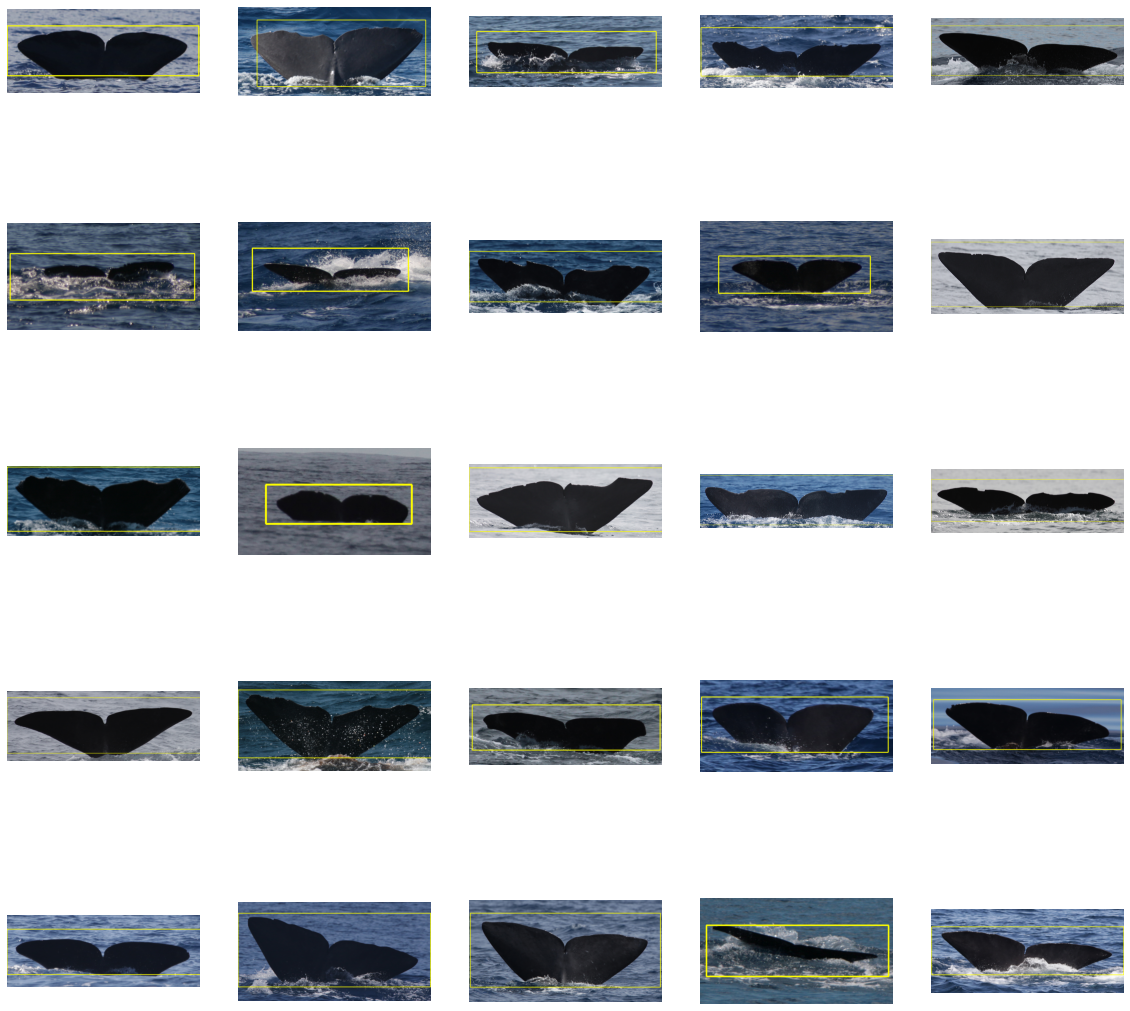

In [51]:
samples = []
for p in data_paths[:25]:
    img         = Image.open(os.path.join(DATA,p)).convert('RGB')
    draw        = Draw(img)
    x0,y0,x1,y1 = tuple(bbox_df.loc[p].tolist())
    x0,y0,x1,y1 = add_margin(x0,y0,x1,y1)
    draw.line([(x0, y0),(x0,y1),(x1,y1),(x1,y0),(x0,y0)], fill='yellow', width=6)
    samples.append(img)
show_whale(samples)

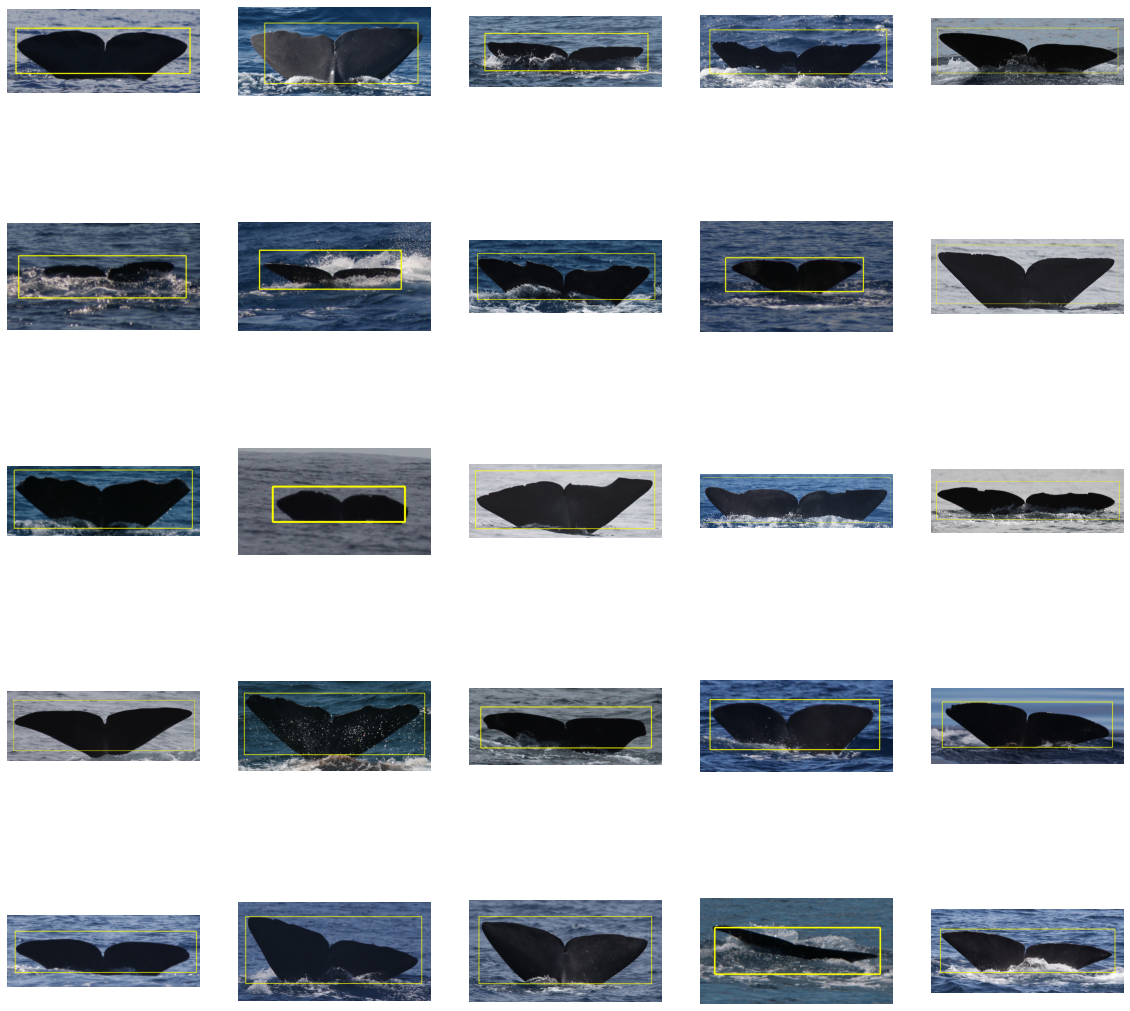

In [52]:
samples = []
for p in data_paths[:25]:
    img         = Image.open(os.path.join(DATA,p)).convert('RGB')
    draw        = Draw(img)
    x0,y0,x1,y1 = tuple(bbox_df.loc[p].tolist())
#     x0,y0,x1,y1 = add_margin(x0,y0,x1,y1)
    draw.line([(x0, y0),(x0,y1),(x1,y1),(x1,y0),(x0,y0)], fill='yellow', width=6)
    samples.append(img)
show_whale(samples)